<a href="https://colab.research.google.com/github/matteoturnu/NetSecProject/blob/main/NetSec_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Studio di correlazione e distribuzione sulle features

## Preparazione dataset

Import Librerie

In [ ]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score

Importazione dataset

In [23]:
url = 'https://raw.githubusercontent.com/matteoturnu/NetSecProject/refs/heads/main/BenignAndMaliciousDataset.csv'
traffic_df = pd.read_csv(url)

print(traffic_df.shape)

(90000, 34)


In [12]:
# We only select numeric and boolean features
numeric_dataset = traffic_df.select_dtypes(include=['number','boolean'])

# We remove Domain because it is an incremental ID
new_numeric_dataset = numeric_dataset.drop(columns='Domain')
# we remove Ip and ASN because they are based on strings "de facto" so it doesn't make sense to study correlation
excluded_features = ['Ip', 'ASN']
new_numeric_dataset = new_numeric_dataset.drop(columns=excluded_features)

## Test di ANOVA per vedere quanto le feature sono significative

In [24]:
# Supponiamo che la colonna 'target' contenga 0 per traffico benevolo e 1 per traffico malevolo
target = 'Class'
feature_columns = [col for col in new_numeric_dataset.columns if col != target]

# Test ANOVA per ciascuna feature numerica
p_values = {}  # Dizionario per salvare i p-values
for feature in feature_columns:
    # Dividi i dati in due gruppi (malevolo e benevolo)
    group_benign = new_numeric_dataset[new_numeric_dataset[target] == 0][feature]
    group_malicious = new_numeric_dataset[new_numeric_dataset[target] == 1][feature]
    # Applica ANOVA
    stat, p_value = stats.f_oneway(group_benign, group_malicious)
    # Salva il p-value per ogni feature
    p_values[feature] = p_value
    # Verifica il risultato
    print(f'Feature: {feature}, P-value: {p_value}')
    if p_value < 0.01:  # Soglia di significatività 0.05
        print(f'La feature {feature} è significativa.')
    else:
        print(f'La feature {feature} NON è significativa.')

KeyError: 'Class'

Previous test shows these features are not important for determining the class

In [14]:
new_numeric_dataset = new_numeric_dataset.drop(columns=['DomainReputation', 'SubdomainNumber'])

## Distribuzione tra benevolo e malevolo delle features

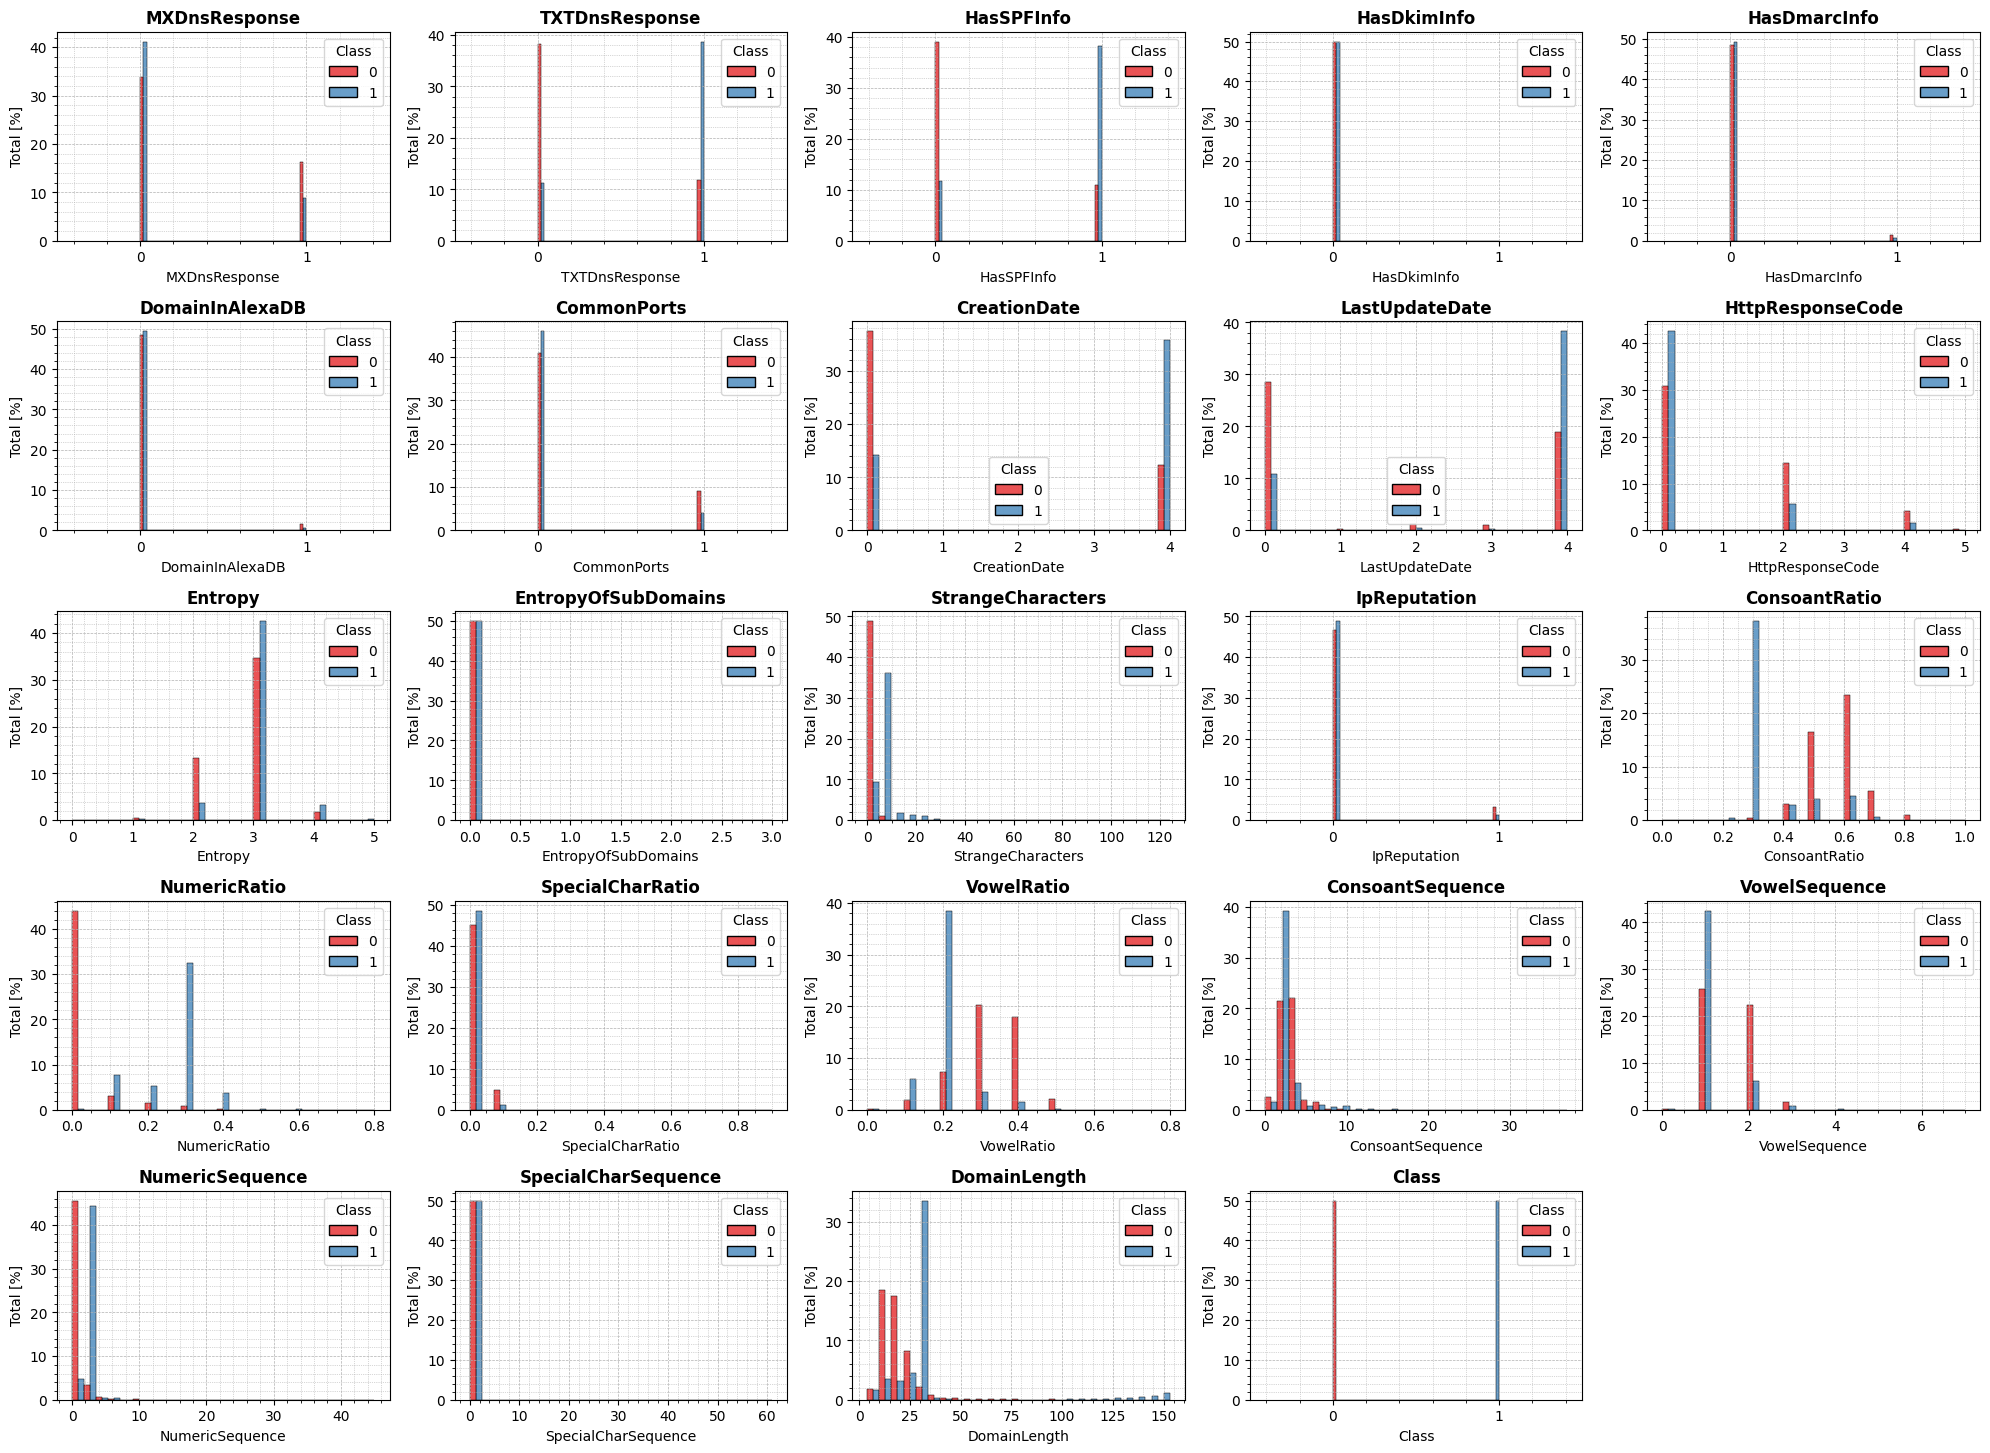

In [15]:
# Crea una figura con sottotrame per ciascuna feature
plt.figure(figsize=(20, 20))

# Cicla attraverso le feature finali
for i, feature in enumerate(new_numeric_dataset, 1):
    plt.subplot(7, 5, i)
    plot = sns.histplot(data=traffic_df, x=feature, hue='Class', multiple='dodge', palette='Set1', bins=25, stat='percent')

    if traffic_df[feature].nunique() == 2:  # Controlla se la feature ha solo 2 valori (booleano)
        plt.xticks([0, 1])
        plt.xlim(-0.5, 1.5)

    plt.title(f'{feature}', fontweight='bold')
    plt.ylabel('Total [%]')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

# Mostra la figura
plt.tight_layout()
plt.show()

I grafici mostrano come alcune features sia equamente distribuite tra campioni malevoli e benevoli

In [16]:
new_numeric_dataset = new_numeric_dataset.drop(columns=['HasDkimInfo', 'HasDmarcInfo', 'DomainInAlexaDB', 'CommonPorts', 'EntropyOfSubDomains', 'IpReputation'])

## Studio di correlazione tra le feature e la classe

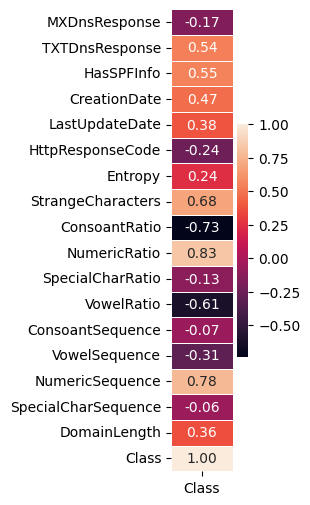

In [17]:
corr_matrix = new_numeric_dataset.corr()
class_corr = corr_matrix[['Class']]
plt.figure(figsize=(1, 6))
sns.heatmap(class_corr, annot=True, linewidths=0.5, fmt='.2f')
plt.show()

Chosen features (based on high correlation with the class)
- TXTDnsResponse
- HasSPFInfo
- StrangeCharacters
- ConsonantRatio
- NumericRatio
- VowelRatio
- NumericSequence

## Studio di correlazione tra le feature

<Axes: >

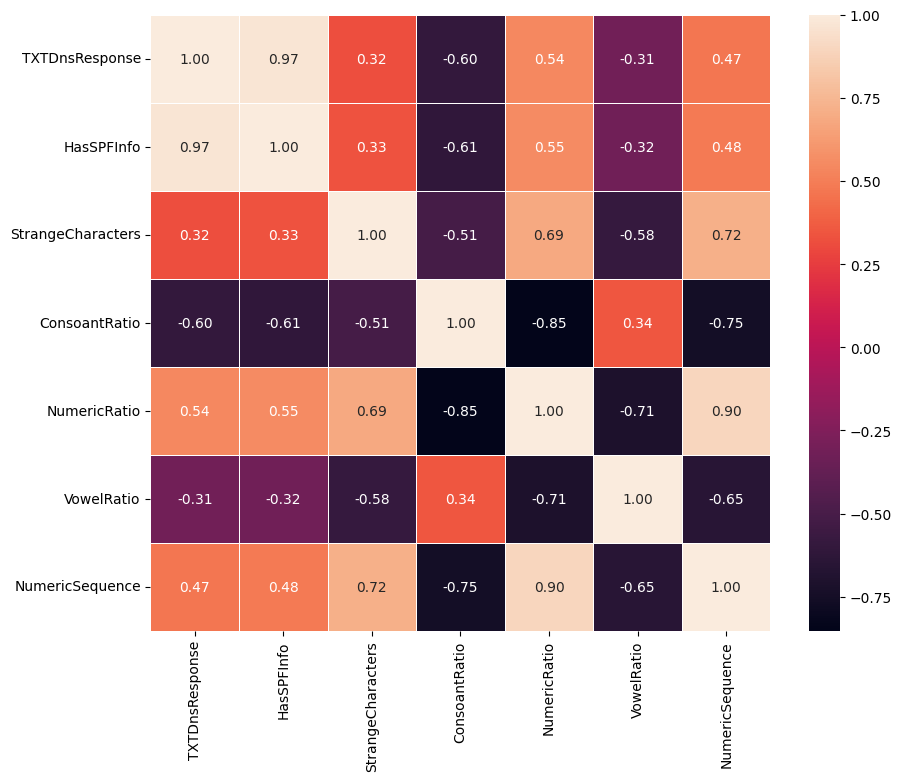

In [18]:
features = ['TXTDnsResponse', 'HasSPFInfo', 'StrangeCharacters', 'ConsoantRatio', 'NumericRatio', 'VowelRatio', 'NumericSequence']
new_numeric_dataset = new_numeric_dataset[features]

corr_matrix = new_numeric_dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f')

Now, looking at correlation between features themselves:
- choosing consonantRatio against NumericRatio
- keeping TXTDnsResponse against HasSPFInfo
- choosing NumericSequence against consonantRatio (4 features left)

Left: NumericSequence, TXTDnsResponse, StrangeCharacters, VowelRatio (next test: maybe remove NumericSequence or VowelRatio)

In [19]:
final_features = ['TXTDnsResponse', 'StrangeCharacters', 'VowelRatio', 'NumericSequence']

# Test to choose classifier

Test to evaluate how much the samples distribution is a Gaussian one


In [ ]:
study_features=['TXTDnsResponse', 'StrangeCharacters', 'VowelRatio', 'NumericSequence', 'Class']
dataset_study=traffic_df[study_features]
dataset_ben= dataset_study[dataset_study['Class']==1]
dataset_mal= dataset_study[dataset_study['Class']==0]

# Esegui il test di Shapiro-Wilk
stat, p_value = stats.shapiro(dataset_ben)

print('Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('Distribuzione probabilmente normale (non rifiuto H0)')
else:
    print('Distribuzione non normale (rifiuto H0)')

stat, p_value = stats.shapiro(dataset_mal)

print('Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('Distribuzione probabilmente normale (non rifiuto H0)')
else:
    print('Distribuzione non normale (rifiuto H0)')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 225000.
  res = hypotest_fun_out(*samples, **kwds)


Statistic: 0.6557978084271938
p-value: 1.0974990318937638e-168
Distribuzione non normale (rifiuto H0)
Statistic: 0.27542616677874854
p-value: 5.985520266058562e-195
Distribuzione non normale (rifiuto H0)


NameError: name 'dataset_ben' is not defined

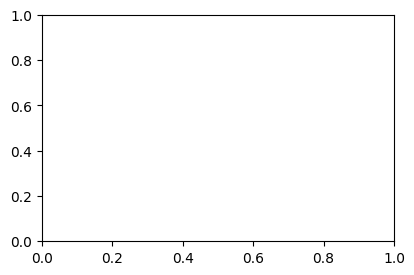

In [25]:
plt.figure(figsize=(10, 10))

i = 1
for feature in final_features[1:]:
  for j in range(2):
    plt.subplot(3, 2, i)
    if i % 2 == 1:
      plot = sns.histplot(data=dataset_ben, x=feature, multiple='dodge', bins=25, stat='percent', color='blue')
    else:
      plot = sns.histplot(data=dataset_mal, x=feature, multiple='dodge', bins=25, stat='percent', color='red')
    i += 1

plt.show()

Sort of probability distribution for each feature. They are NO gaussian ones so it's not possible to suppose that data has Gaussian distribution

# K-NN

In [26]:
y = traffic_df['Class']

# k values to try
k_values = [5, 10, 20, 50, 100, 200, 300]

## Test for chosen features

K-NN con tutte le 4 features

Accuracy: 0.96
True Positive Ratio: 0.97
False Negative Ratio: 0.03
Precision: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     13378
           1       0.94      0.97      0.96     13622

    accuracy                           0.96     27000
   macro avg       0.96      0.96      0.96     27000
weighted avg       0.96      0.96      0.96     27000

k=1, Accuracy: 0.93
k=3, Accuracy: 0.95
k=5, Accuracy: 0.96
k=7, Accuracy: 0.96
k=9, Accuracy: 0.96
k=11, Accuracy: 0.96


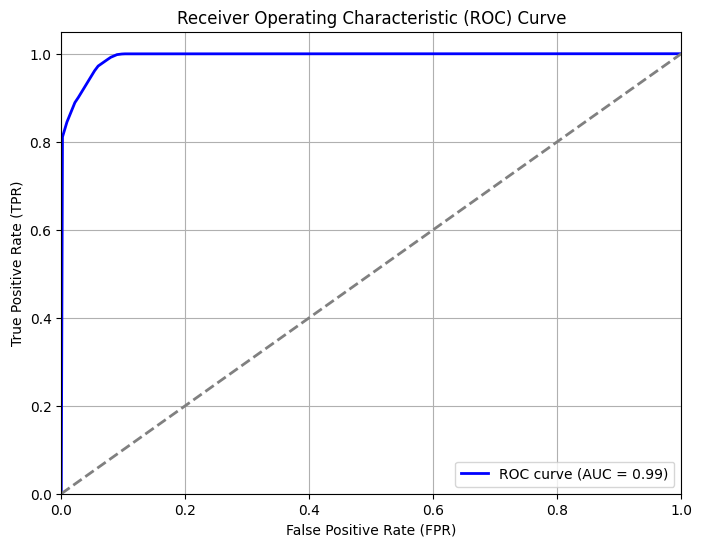

In [21]:
X = traffic_df[final_features] # 4 features

# X = traffic_df[final_features] # Sostituisci con le tue feature

# Suddividi il dataset in 70% training e 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizzazione delle feature per KNN
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Addestramento del modello
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Valutazione del modello
y_pred = knn.predict(X_test)

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)

TP = cm[1, 1]  # Veri positivi
TN = cm[0, 0]  # Veri negativi
FP = cm[0, 1]  # Falsi positivi
FN = cm[1, 0]  # Falsi negativi

TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
FNR = FN / (TP + FN) if (TP + FN) > 0 else 0

P = TP/(TP+FP) if (TP+FP) > 0 else 0

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'True Positive Ratio: {TPR:.2f}')
print(f'False Negative Ratio: {FNR:.2f}')
print(f'Precision: {P:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Test su accuratezza per diversi valori di k
k_values = [1, 3, 5, 7, 9, 11]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    print(f'k={k}, Accuracy: {accuracy_score(y_test, y_pred):.2f}')

# --- CURVA ROC E CALCOLO AUC ---
# Prevedi le probabilità delle classi positive
y_prob = knn.predict_proba(X_test)[:, 1]

# Calcola fpr, tpr e soglie per la ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcola AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Traccia la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


K-NN sulle 4 features prese singolarmente


Analizzando la feature: TXTDnsResponse
Accuracy: 0.77
True Positive Ratio: 0.78
False Negative Ratio: 0.22
Precision: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77     13378
           1       0.77      0.78      0.77     13622

    accuracy                           0.77     27000
   macro avg       0.77      0.77      0.77     27000
weighted avg       0.77      0.77      0.77     27000


Analizzando la feature: StrangeCharacters
Accuracy: 0.82
True Positive Ratio: 0.84
False Negative Ratio: 0.16
Precision: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     13378
           1       0.82      0.84      0.83     13622

    accuracy                           0.82     27000
   macro avg       0.82      0.82      0.82     27000
weighted avg       0.82      0.82      0.82     27000


Analizzando la feature: VowelRatio
Accuracy: 0.8

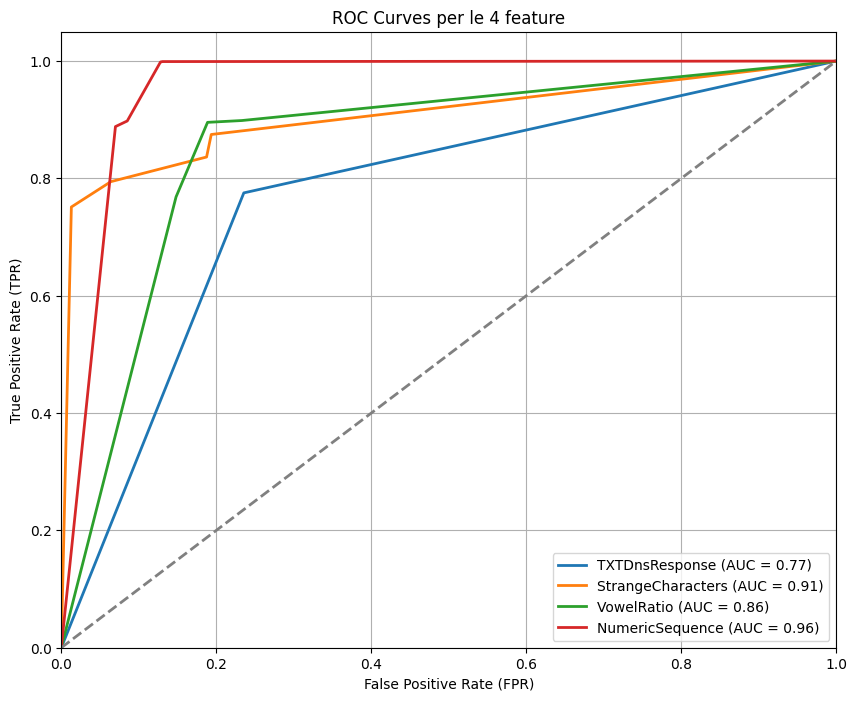

In [22]:
plt.figure(figsize=(10, 8))

for feature in X:
    print(f"\nAnalizzando la feature: {feature}")

    feature_vector = traffic_df[feature].values.reshape(-1, 1)  # Reshape per ottenere una 2D array

    X_train, X_test, y_train, y_test = train_test_split(feature_vector, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    k = 5
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Valutazione del modello
    y_pred = knn.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    TP = cm[1, 1]  # Veri positivi
    TN = cm[0, 0]  # Veri negativi
    FP = cm[0, 1]  # Falsi positivi
    FN = cm[1, 0]  # Falsi negativi

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0

    P = TP / (TP + FP) if (TP + FP) > 0 else 0

    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(f'True Positive Ratio: {TPR:.2f}')
    print(f'False Negative Ratio: {FNR:.2f}')
    print(f'Precision: {P:.2f}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    # Prevedi le probabilità della classe positiva
    y_prob = knn.predict_proba(X_test)[:, 1]

    # Calcola fpr, tpr e soglie per la ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calcola AUC
    roc_auc = roc_auc_score(y_test, y_prob)

    # Traccia la curva ROC per ogni feature
    plt.plot(fpr, tpr, lw=2, label=f'{feature} (AUC = {roc_auc:.2f})')

# Aggiungi dettagli al grafico
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Linea diagonale per classificatore casuale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves per le 4 feature')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Test for excluded features

In [ ]:
X = traffic_df[excluded_features]

for feature in X:
  print(f"\nAnalizzando la feature: {feature}")

  feature_vector = traffic_df[feature].values.reshape(-1, 1)  # Reshape per ottenere una 2D array

  X_train, X_test, y_train, y_test = train_test_split(feature_vector, y, test_size=0.3, random_state=42)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  k = 5
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)

  # Model evaluation
  y_pred = knn.predict(X_test)

  cm = confusion_matrix(y_test, y_pred)

  TP = cm[1, 1]  # veri positivi
  TN = cm[0, 0]  # veri negativi
  FP = cm[0, 1]  # falsi positivi
  FN = cm[1, 0]  # falsi negativi

  TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
  FNR = FN / (TP + FN) if (TP + FN) > 0 else 0

  P = TP/(TP+FP)

  print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
  print(f'True Positive Ratio: {TPR:.2f}')
  print(f'False Negative Ratio: {FNR:.2f}')
  print(f'Precision: {P:.2f}')
  print('Classification Report:')
  print(classification_report(y_test, y_pred))

  for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f'k={k}, Accuracy: {accuracy_score(y_test, y_pred):.2f}')


Analizzando la feature: Ip
Accuracy: 0.89
True Positive Ratio: 0.82
False Negative Ratio: 0.18
Precision: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     13378
           1       0.95      0.82      0.88     13622

    accuracy                           0.89     27000
   macro avg       0.89      0.89      0.89     27000
weighted avg       0.89      0.89      0.89     27000

k=5, Accuracy: 0.89
k=10, Accuracy: 0.89
k=20, Accuracy: 0.89
k=50, Accuracy: 0.89
k=100, Accuracy: 0.88
k=200, Accuracy: 0.87
k=300, Accuracy: 0.87

Analizzando la feature: ASN
Accuracy: 0.87
True Positive Ratio: 0.81
False Negative Ratio: 0.19
Precision: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     13378
           1       0.92      0.81      0.87     13622

    accuracy                           0.87     27000
   macro avg       0.88      0.87  